In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pwd
import os
os.chdir('/content/drive/MyDrive/airbnb-amenity-detection/')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/MyDrive/airbnb-amenity-detection


# GCP Data Manipulation

This notebook is dedicated to shifting data around my various GCP buckets.

I'd like the following my bucket:
* 1 folder with all the data (train/valid/test & val_test, a combination of valid + test)
* 1 folder with 10% of the data (train/test) - this should have the same distribution as the whole data

**Note:** I've combined the validation and test folders in `/val_test/`.

Mainly working with this resource: https://cloud.google.com/storage/docs/gsutil/commands/cp

In [ ]:
import os
# Get all filepaths
train_imgs = os.listdir("train")
val_imgs = os.listdir("validation")
test_imgs = os.listdir("val_test")
train_imgs[:3],len(test_imgs), len(train_imgs)

(['6278bad1cc9ce545.jpg', 'b8f0b3b3b113b57b.jpg', 'e7190bfc511e5997.jpg'],
 2854,
 34835)

In [ ]:
len(train_imgs), len(val_imgs), len(test_imgs)

(34835, 741, 2854)

In [ ]:
# Make folder which combines validation and test images (val images only have 800, test images only have 2000)
os.mkdir("val_test")
!cp -a validation/. val_test/
!cp -a test/. val_test/

In [ ]:
# Check length of combined validation and test images
val_test_imgs = os.listdir("val_test")
print(len(val_test_imgs) == len(val_imgs + test_imgs))
len(val_test_imgs)

False


2854

In [ ]:
# # Use filepaths to move 10% of val_test and train (at random) into subset folders
os.mkdir("train_10")
os.mkdir("val_test_10")

In [ ]:
from shutil import copy
import random

# Get random 10% of trian/val_test image paths
train_10_imgs = random.sample(train_imgs, len(train_imgs)//10)
val_test_10_imgs = random.sample(val_test_imgs, len(val_test_imgs)//10)
len(train_10_imgs), len(val_test_10_imgs)

(3483, 285)

In [ ]:
# Move 10% of train images into their own folder
for img in train_10_imgs:
    #print(f"Copying: {img}")
    copy("train/"+img, "train_10")

In [ ]:
# Move 10% of val_test images into their own folder
for img in val_test_10_imgs:
    #print(f"Copying: {img}")
    copy("val_test/"+img, "val_test_10")

In [ ]:
len(os.listdir("train_10")), len(os.listdir("val_test_10"))

(3483, 285)

In [ ]:
# Check to see if train_10 matches the images in the folder
print(sorted(os.listdir("train_10")) == sorted(train_10_imgs))
print(sorted(os.listdir("val_test_10")) == sorted(val_test_10_imgs))

False
False


## Move images to GCP
Now some data manipulation has happened, time to move all image folders to a GCP bucket for later use.

Example GCP code: `gsutil cp *.txt gs://my-bucket` (moves all `.txt` files in current directory to `my-bucket` on GCP.

When copying large amounts of files, I should use: `gsutil -m cp -r dir gs://my-bucket`

In [ ]:
from google.colab import auth
auth.authenticate_user()
project_id = 'idyllic-now-268910'
!gcloud config set project {project_id}
!gsutil ls

# # 10% of training data
!gsutil -m cp -r train_10 gs://airbnb-amenity-detection/open-images-data

# # Training data
!gsutil -m cp -r train gs://airbnb-amenity-detection/open-images-data

# # Combined validation and test sets
!gsutil -m cp -r val_test gs://airbnb-amenity-detection/open-images-data
    
# # 10% of combined validation and test sets
!gsutil -m cp -r val_test_10 gs://airbnb-amenity-detection/open-images-data

## Check distributions of images
Figure out the distributions of different classes of images in my datasets.
* Do they match Airbnb's distributions?
* Are the train/test splits (the 10%) representative of what's going on in the full datasets?

In [ ]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
# !pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
# !pip install cython pyyaml==5.1
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# install detectron2:
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

# WandB - Install the W&B library
# !pip install wandb -q

# Need awscli to download images from AWS (labels come from GCP)
# !pip install awscli

print("#### Versions: ####")
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

#### Versions: ####
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
import logging
import os
import argparse
from collections import OrderedDict
import pandas as pd
import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import default_argument_parser, default_setup, launch
from detectron2.evaluation import ( ### Changes from original, I don't need all the different evaluators
    COCOEvaluator,
    DatasetEvaluators,
    inference_on_dataset,
    print_csv_format
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
# Not sure what these do but they may help to track experiments
from detectron2.utils.events import (
    CommonMetricPrinter,
    EventStorage,
    JSONWriter,
    TensorboardXWriter
)

from detectron2.utils.visualizer import Visualizer

# Setup logger
logger = logging.getLogger("detectron2")

In [ ]:
# import some common libraries
import cv2
import json
import random
import os
import pandas as pd
import numpy as np
#from google.colab.patches import cv2_imshow
from tqdm import tqdm

# wandb - Import weight's & biases
import wandb

import torch, torchvision
print(torch.__version__)
!gcc --version
# opencv is pre-installed on colab

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


1.4.0+cu100
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
import pandas as pd
from preprocessing import format_annotations

In [ ]:
# Classes of amenities Airbnb mostly cares about
subset = ['Toilet',
         'Swimming pool',
         'Bed',
         'Billiard table',
         'Sink',
         'Fountain',
         'Oven',
         'Ceiling fan',
         'Television',
         'Microwave oven',
         'Gas stove',
         'Refrigerator',
         'Kitchen & dining room table',
         'Washing machine',
         'Bathtub',
         'Stairs',
         'Fireplace',
         'Pillow',
         'Mirror',
         'Shower',
         'Couch',
         'Countertop',
         'Coffeemaker',
         'Dishwasher',
         'Sofa bed',
         'Tree house',
         'Towel',
         'Porch',
         'Wine rack',
         'Jacuzzi']

In [ ]:
valid_annots = format_annotations(image_folder="validation", 
                                  annotation_file="validation-annotations-bbox.csv", 
                                  target_classes=subset)
valid_annots.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
14593,11dcac4ca5923a58,freeform,/m/03dnzn,1,0.360645,0.999988,0.000000,1.000000,0,1,0,0,0,Bathtub,0
173624,d7d469cb4c7e8cd2,freeform,/m/03dnzn,1,0.000081,0.999159,0.435396,1.000000,0,1,0,0,0,Bathtub,0
190024,eccb080e57b2aac5,freeform,/m/03dnzn,1,0.303341,0.905829,0.470852,0.999948,0,0,0,0,0,Bathtub,0
106087,837b3d11ff02f116,freeform,/m/03dnzn,1,0.000000,0.669035,0.372941,1.000000,0,1,0,0,0,Bathtub,0
114459,8e562fee6ff208f7,freeform,/m/03dnzn,1,0.494666,0.983858,0.546178,1.000000,0,1,0,0,0,Bathtub,0


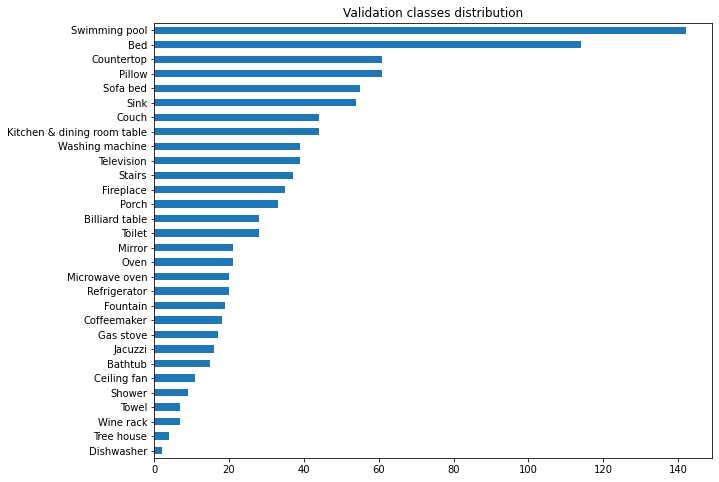

In [ ]:
valid_annots.ClassName.value_counts().sort_values().plot(kind="barh", title="Validation classes distribution", figsize=(10, 8));

In [ ]:
valid_annots.to_csv("subset-valid-annotations.csv", index=False)

### Training distribution

In [ ]:
train_annots = format_annotations(image_folder="train", 
                                  annotation_file="train-annotations-bbox.csv", 
                                  target_classes=subset)
train_annots.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
3454445,38bbd240e3dd6d2b,xclick,/m/03dnzn,1,0.00,0.997917,0.362500,0.998438,1,1,0,0,0,Bathtub,0
9051090,9a2f2850b2b6895e,xclick,/m/03dnzn,1,0.00,0.823750,0.382500,0.999167,1,1,0,0,0,Bathtub,0
6401293,6be60d5453217a0e,xclick,/m/03dnzn,1,0.00,0.999375,0.361163,0.917448,1,1,0,0,0,Bathtub,0
1158763,1123ab5e8d902bcb,xclick,/m/03dnzn,1,0.00,0.999375,0.391714,0.999058,1,1,0,0,0,Bathtub,0
533268,06e19a68abf5dde4,xclick,/m/03dnzn,1,0.24,0.630000,0.515625,0.930625,1,0,0,0,0,Bathtub,0


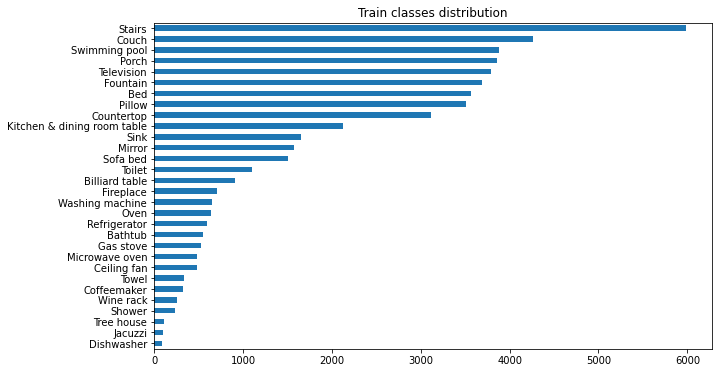

In [ ]:
train_annots.ClassName.value_counts().sort_values().plot(kind="barh", title="Train classes distribution", figsize=(10, 6));

In [ ]:
train_annots.ClassName.value_counts()

Stairs                         5981
Couch                          4259
Swimming pool                  3881
Porch                          3854
Television                     3789
Fountain                       3691
Bed                            3563
Pillow                         3508
Countertop                     3113
Kitchen & dining room table    2127
Sink                           1648
Mirror                         1572
Sofa bed                       1501
Toilet                         1099
Billiard table                  912
Fireplace                       711
Washing machine                 655
Oven                            637
Refrigerator                    592
Bathtub                         545
Gas stove                       526
Microwave oven                  485
Ceiling fan                     478
Towel                           338
Coffeemaker                     323
Wine rack                       254
Shower                          235
Tree house                  

In [ ]:
# Save formatted and subset of annotations to CSV
train_annots.to_csv("subset-train-annotations.csv", index=False)

### Test distribution

In [ ]:
test_annots = format_annotations(image_folder="test", 
                                     annotation_file="test-annotations-bbox.csv", 
                                     target_classes=subset)
test_annots.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
431305,ad2e3b563bf9eef5,freeform,/m/03dnzn,1,0.000035,1.000000,0.000007,1.000000,0,0,0,0,0,Bathtub,0
611091,f9f6d0ce7325d286,freeform,/m/03dnzn,1,0.012309,0.933887,0.781339,1.000000,0,0,0,0,0,Bathtub,0
400753,a108e2b6835d757c,freeform,/m/03dnzn,1,0.000104,0.999913,0.142911,0.999998,0,0,0,0,0,Bathtub,0
388381,9bbe5902409bfdca,freeform,/m/03dnzn,1,0.641643,1.000000,0.539640,1.000000,0,1,0,0,0,Bathtub,0
56610,1574c030df3accac,freeform,/m/03dnzn,1,0.089474,0.423140,0.450507,0.830147,0,0,0,0,0,Bathtub,0


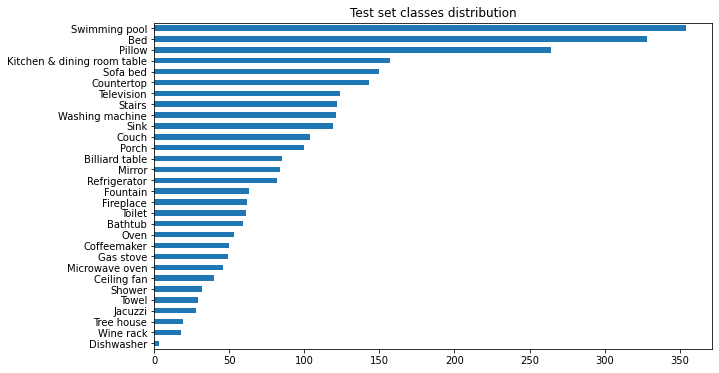

In [ ]:
test_annots.ClassName.value_counts().sort_values().plot(kind="barh", title="Test set classes distribution", figsize=(10, 6));

In [ ]:
test_annots.ClassName.value_counts()

Swimming pool                  354
Bed                            328
Pillow                         264
Kitchen & dining room table    157
Sofa bed                       150
Countertop                     143
Television                     124
Stairs                         122
Washing machine                121
Sink                           119
Couch                          104
Porch                          100
Billiard table                  85
Mirror                          84
Refrigerator                    82
Fountain                        63
Fireplace                       62
Toilet                          61
Bathtub                         59
Oven                            53
Coffeemaker                     50
Gas stove                       49
Microwave oven                  46
Ceiling fan                     40
Shower                          32
Towel                           29
Jacuzzi                         28
Tree house                      19
Wine rack           

### 10% of training data distribution

In [ ]:
train_10_annots = format_annotations(image_folder="train_10", 
                                     annotation_file="train-annotations-bbox.csv", 
                                     target_classes=subset)
train_10_annots.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
12091342,cf7962141bd10ccd,xclick,/m/03dnzn,1,0.000000,0.998182,0.597426,0.998162,1,1,0,0,0,Bathtub,0
5326850,5955a3d0b07ac57f,xclick,/m/03dnzn,1,0.000000,0.998438,0.435417,0.997917,1,1,0,0,0,Bathtub,0
11151925,bf1659a6948fd6f6,xclick,/m/03dnzn,1,0.139167,0.999167,0.344375,0.999375,1,1,0,0,0,Bathtub,0
13266145,e4b8830f06b38e4d,xclick,/m/03dnzn,1,0.000000,0.999155,0.021127,0.998826,1,1,0,0,0,Bathtub,0
446367,058becfeae2bb2da,xclick,/m/03dnzn,1,0.000000,0.998843,0.000000,0.998599,1,1,0,0,0,Bathtub,0


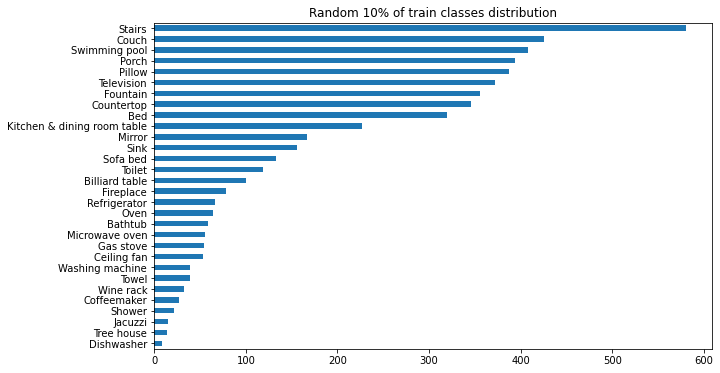

In [ ]:
train_10_annots.ClassName.value_counts().sort_values().plot(kind="barh", title="Random 10% of train classes distribution", figsize=(10, 6));

In [ ]:
train_10_annots.ClassName.value_counts()

Stairs                         580
Couch                          425
Swimming pool                  408
Porch                          394
Pillow                         387
Television                     372
Fountain                       356
Countertop                     346
Bed                            320
Kitchen & dining room table    227
Mirror                         167
Sink                           156
Sofa bed                       133
Toilet                         119
Billiard table                 100
Fireplace                       78
Refrigerator                    66
Oven                            64
Bathtub                         59
Microwave oven                  55
Gas stove                       54
Ceiling fan                     53
Washing machine                 39
Towel                           39
Wine rack                       32
Coffeemaker                     27
Shower                          22
Jacuzzi                         15
Tree house          

In [ ]:
# Save train_10 annotations to CSV
train_10_annots.to_csv("subset-train-10-annotations.csv", index=False)

## Combine Test & Validation Labels

Since I'm using a data split called val_test (combination of validation and test labels), I need to combine them.

In [ ]:
val_annotations = pd.read_csv("validation-annotations-bbox.csv")
test_annotations = pd.read_csv("test-annotations-bbox.csv")
val_annotations.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0001eeaf4aed83f9,freeform,/m/0cmf2,1,0.022464,0.964178,0.070656,0.800164,0,0,0,0,0
1,000595fe6fee6369,freeform,/m/02wbm,1,0.000000,1.000000,0.000233,1.000000,0,0,1,0,0
2,000595fe6fee6369,freeform,/m/02xwb,1,0.141030,0.180277,0.676262,0.732455,0,0,0,0,0
3,000595fe6fee6369,freeform,/m/02xwb,1,0.213781,0.253028,0.298764,0.354956,1,0,0,0,0
4,000595fe6fee6369,freeform,/m/02xwb,1,0.232926,0.288447,0.488954,0.545146,1,0,0,0,0


In [ ]:
# Combine test & validation annotations into 1 file
val_test_annotations = val_annotations.append(test_annotations)
len(val_test_annotations), len(val_annotations) + len(test_annotations)

(829903, 829903)

In [ ]:
# Save to CSV for later use
# val_test_annotations.to_csv("val-test-annotations.csv", index=False)

In [ ]:
val_test_annots = format_annotations(image_folder="val_test",
                                     annotation_file="val-test-annotations.csv",
                                     target_classes=subset)
val_test_annots

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
773697,e8a1eeab44700143,freeform,/m/03dnzn,1,0.000000,0.999903,0.001539,1.000000,0,0,0,0,0,Bathtub,0
635926,ad2e3b563bf9eef5,freeform,/m/03dnzn,1,0.000035,1.000000,0.000007,1.000000,0,0,0,0,0,Bathtub,0
190024,eccb080e57b2aac5,freeform,/m/03dnzn,1,0.303341,0.905829,0.470852,0.999948,0,0,0,0,0,Bathtub,0
387878,463390a3e513f69d,freeform,/m/03dnzn,1,0.217215,1.000000,0.000586,1.000000,0,1,0,0,0,Bathtub,0
562935,8f6975b5dff66a1c,freeform,/m/03dnzn,1,0.059365,1.000000,0.199632,0.999478,0,0,0,0,0,Bathtub,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689776,c513d9de623bf69a,freeform,/m/0271qf7,1,0.000000,1.000000,0.000037,1.000000,0,1,1,0,0,Wine rack,29
384546,44d324ebd3e22ad7,freeform,/m/0271qf7,1,0.000000,0.999920,0.319686,0.991159,0,0,0,0,0,Wine rack,29
785855,edbf1e4b20a2c600,freeform,/m/0271qf7,1,0.342378,0.975027,0.109912,0.858150,0,0,1,0,0,Wine rack,29
751406,df121902c6f54c2f,freeform,/m/0271qf7,1,0.000000,1.000000,0.000000,0.999996,0,1,0,0,0,Wine rack,29


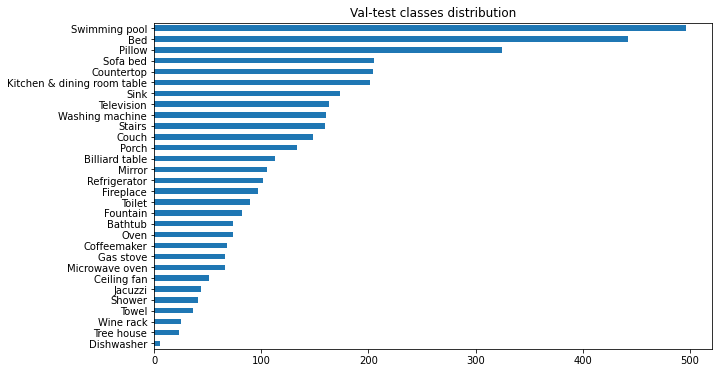

In [ ]:
val_test_annots.ClassName.value_counts().sort_values().plot(kind="barh", title="Val-test classes distribution", figsize=(10, 6));

In [ ]:
val_test_annots.ClassName.value_counts()

Swimming pool                  496
Bed                            442
Pillow                         325
Sofa bed                       205
Countertop                     204
Kitchen & dining room table    201
Sink                           173
Television                     163
Washing machine                160
Stairs                         159
Couch                          148
Porch                          133
Billiard table                 113
Mirror                         105
Refrigerator                   102
Fireplace                       97
Toilet                          89
Fountain                        82
Bathtub                         74
Oven                            74
Coffeemaker                     68
Gas stove                       66
Microwave oven                  66
Ceiling fan                     51
Jacuzzi                         44
Shower                          41
Towel                           36
Wine rack                       25
Tree house          

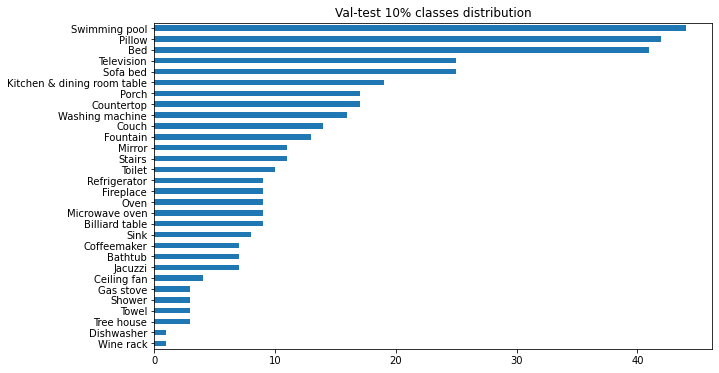

In [ ]:
# Sample 10% of the data & check distributions 
val_test_10_annots = val_test_annots.sample(frac=0.1)
val_test_10_annots.ClassName.value_counts().sort_values().plot(kind="barh", title="Val-test 10% classes distribution", figsize=(10, 6));

In [ ]:
# Save val_test_10_image_ids to list
val_test_10_image_ids = list(set(val_test_10_annots.ImageID.tolist()))
val_test_10_image_ids[:10], len(val_test_10_image_ids)

(['eef263b4922c1dae',
  'beae33ddea0481f1',
  '81ad10298ce57667',
  'c48bab4796ca5e02',
  '9526a7f097f44677',
  'f6afa3fbb4fbc588',
  '1f2dc2f1001d56d7',
  '570e89b0937f01d2',
  'f0b018ce550add28',
  'c8c25adb2915d95d'],
 373)

In [ ]:
# # Move val_test_10_image_ids images to val_test_10 (replace the ones which are there)
# from shutil import copy

# # Move 10% of val_test images into their own folder
# for img in val_test_10_image_ids:
#     #print(f"Copying: {img}")
#     copy("val_test/"+img+".jpg", "val_test_10")

### 10% of val-test image distributions

In [ ]:
val_test_10_annots = format_annotations(image_folder="val_test_10", 
                                        annotation_file="val-test-annotations.csv", 
                                        target_classes=subset)
val_test_10_annots.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
773697,e8a1eeab44700143,freeform,/m/03dnzn,1,0.000000,0.999903,0.001539,1.000000,0,0,0,0,0,Bathtub,0
190024,eccb080e57b2aac5,freeform,/m/03dnzn,1,0.303341,0.905829,0.470852,0.999948,0,0,0,0,0,Bathtub,0
387878,463390a3e513f69d,freeform,/m/03dnzn,1,0.217215,1.000000,0.000586,1.000000,0,1,0,0,0,Bathtub,0
684706,c2ddf0678c9cfe8c,freeform,/m/03dnzn,1,0.244279,0.887022,0.497204,1.000000,0,0,0,0,0,Bathtub,0
106087,837b3d11ff02f116,freeform,/m/03dnzn,1,0.000000,0.669035,0.372941,1.000000,0,1,0,0,0,Bathtub,0


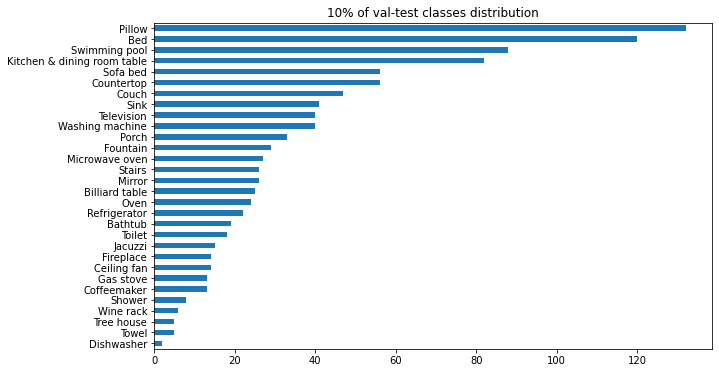

In [ ]:
val_test_10_annots.ClassName.value_counts().sort_values().plot(kind="barh", title="10% of val-test classes distribution", figsize=(10, 6));

In [ ]:
val_test_10_annots.ClassName.value_counts()

Pillow                         132
Bed                            120
Swimming pool                   88
Kitchen & dining room table     82
Sofa bed                        56
Countertop                      56
Couch                           47
Sink                            41
Television                      40
Washing machine                 40
Porch                           33
Fountain                        29
Microwave oven                  27
Stairs                          26
Mirror                          26
Billiard table                  25
Oven                            24
Refrigerator                    22
Bathtub                         19
Toilet                          18
Jacuzzi                         15
Fireplace                       14
Ceiling fan                     14
Gas stove                       13
Coffeemaker                     13
Shower                           8
Wine rack                        6
Towel                            5
Tree house          

In [ ]:
# Save val_test_10% annotations to CSV
val_test_10_annots.to_csv("subset-val-test-10-annotations.csv")

## Create labels of images/image splits 

Create all JSON labels for all splits of data. Check to see if the preprocessing functions work for each dataset split. 

In [ ]:
from preprocessing import get_image_dicts

In [ ]:
# Create validation image dictionaries
val_img_dicts = get_image_dicts("validation",
                                "validation-annotations-bbox.csv",
                                target_classes=subset)

Using validation-annotations-bbox.csv for annotations...
On dataset: validation
Classes we're using:
 Swimming pool                  142
Bed                            114
Countertop                      61
Pillow                          61
Sofa bed                        55
Sink                            54
Couch                           44
Kitchen & dining room table     44
Washing machine                 39
Television                      39
Stairs                          37
Fireplace                       35
Porch                           33
Billiard table                  28
Toilet                          28
Mirror                          21
Oven                            21
Microwave oven                  20
Refrigerator                    20
Fountain                        19
Coffeemaker                     18
Gas stove                       17
Jacuzzi                         16
Bathtub                         15
Ceiling fan                     11
Shower                 

271it [00:09, 39.22it/s]

In [ ]:
# Create val_test image dictionaries
val_test_img_dicts = get_image_dicts("val_test",
                                     "val-test-annotations.csv",
                                     target_classes=subset)

Using val-test-annotations.csv for annotations...
On dataset: val_test
Classes we're using:
 Swimming pool                  496
Bed                            442
Pillow                         325
Sofa bed                       205
Countertop                     204
Kitchen & dining room table    201
Sink                           173
Television                     163
Washing machine                160
Stairs                         159
Couch                          148
Porch                          133
Billiard table                 113
Mirror                         105
Refrigerator                   102
Fireplace                       97
Toilet                          89
Fountain                        82
Bathtub                         74
Oven                            74
Coffeemaker                     68
Gas stove                       66
Microwave oven                  66
Ceiling fan                     51
Jacuzzi                         44
Shower                          

2853it [01:15, 37.82it/s]


Saving labels to: val_test/val_test_labels.json...


In [ ]:
# Create train image dictionaries
train_img_dicts = get_image_dicts("train",
                                  "train-annotations-bbox.csv",
                                  target_classes=subset)

Using train-annotations-bbox.csv for annotations...
On dataset: train
Classes we're using:
 Stairs                         5981
Couch                          4259
Swimming pool                  3881
Porch                          3854
Television                     3789
Fountain                       3691
Bed                            3563
Pillow                         3508
Countertop                     3113
Kitchen & dining room table    2127
Sink                           1648
Mirror                         1572
Sofa bed                       1501
Toilet                         1099
Billiard table                  912
Fireplace                       711
Washing machine                 655
Oven                            637
Refrigerator                    592
Bathtub                         545
Gas stove                       526
Microwave oven                  485
Ceiling fan                     478
Towel                           338
Coffeemaker                     323
Wine rac

34835it [23:56, 24.26it/s]


Saving labels to: train/train_labels.json...


In [ ]:
# Create train 10% image dictionaries
train_10_img_dicts = get_image_dicts("train_10",
                                     "train-annotations-bbox.csv",
                                     target_classes=subset)

Using train-annotations-bbox.csv for annotations...
On dataset: train_10
Classes we're using:
 Stairs                         580
Couch                          425
Swimming pool                  408
Porch                          394
Pillow                         387
Television                     372
Fountain                       356
Countertop                     346
Bed                            320
Kitchen & dining room table    227
Mirror                         167
Sink                           156
Sofa bed                       133
Toilet                         119
Billiard table                 100
Fireplace                       78
Refrigerator                    66
Oven                            64
Bathtub                         59
Microwave oven                  55
Gas stove                       54
Ceiling fan                     53
Washing machine                 39
Towel                           39
Wine rack                       32
Coffeemaker                   

3483it [01:47, 32.27it/s]


Saving labels to: train_10/train_10_labels.json...


In [ ]:
# Create val_test 10% image dictionaries
val_test_10_img_dicts = get_image_dicts("val_test_10",
                                        "val-test-annotations.csv",
                                        target_classes=subset)

Using val-test-annotations.csv for annotations...
On dataset: val_test_10
Classes we're using:
 Pillow                         132
Bed                            120
Swimming pool                   88
Kitchen & dining room table     82
Sofa bed                        56
Countertop                      56
Couch                           47
Sink                            41
Television                      40
Washing machine                 40
Porch                           33
Fountain                        29
Microwave oven                  27
Stairs                          26
Mirror                          26
Billiard table                  25
Oven                            24
Refrigerator                    22
Bathtub                         19
Toilet                          18
Jacuzzi                         15
Fireplace                       14
Ceiling fan                     14
Gas stove                       13
Coffeemaker                     13
Shower                       

629it [00:18, 33.82it/s]

Saving labels to: val_test_10/val_test_10_labels.json...


In [ ]:
# Create test labels in JSON
test_img_dicts = get_image_dicts("test",
                                 "test-annotations-bbox.csv",
                                 target_classes=subset)

Using test-annotations-bbox.csv for annotations...
On dataset: test
Classes we're using:
 Swimming pool                  354
Bed                            328
Pillow                         264
Kitchen & dining room table    157
Sofa bed                       150
Countertop                     143
Television                     124
Stairs                         122
Washing machine                121
Sink                           119
Couch                          104
Porch                          100
Billiard table                  85
Mirror                          84
Refrigerator                    82
Fountain                        63
Fireplace                       62
Toilet                          61
Bathtub                         59
Oven                            53
Coffeemaker                     50
Gas stove                       49
Microwave oven                  46
Ceiling fan                     40
Shower                          32
Towel                           29


2112it [01:07, 31.36it/s]


Saving labels to: test/test_labels.json...


In [ ]:
# # Save JSON labels to GCP
# !gsutil -m cp -r val_test_10/*.json gs://airbnb-amenity-detection/open-images-data
# !gsutil -m cp -r val_test/*.json gs://airbnb-amenity-detection/open-images-data
# !gsutil -m cp -r test/*.json gs://airbnb-amenity-detection/open-images-data
# !gsutil -m cp -r validation/*.json gs://airbnb-amenity-detection/open-images-data
# !gsutil -m cp -r train/*.json gs://airbnb-amenity-detection/open-images-data
!gsutil -m cp -r train_10/*.json gs://airbnb-amenity-detection/open-images-data

Copying file://train_10/train_10_labels.json [Content-Type=application/json]...
/ [1/1 files][752.9 KiB/752.9 KiB] 100% Done                                    
Operation completed over 1 objects/752.9 KiB.                                    


In [ ]:
!gsutil -m cp -r output gs://airbnb-amenity-detection/open-images-data

Copying file://output/log.txt [Content-Type=text/plain]...
Copying file://output/events.out.tfevents.1643665778.4e9f336d25f0.36765.4 [Content-Type=application/octet-stream]...
Copying file://output/metrics.json [Content-Type=application/json]...
Copying file://output/config.yaml [Content-Type=application/octet-stream]...
Copying file://output/events.out.tfevents.1643665354.4e9f336d25f0.36765.2 [Content-Type=application/octet-stream]...
Copying file://output/events.out.tfevents.1643664856.4e9f336d25f0.36765.0 [Content-Type=application/octet-stream]...
Copying file://output/events.out.tfevents.1643665024.4e9f336d25f0.36765.1 [Content-Type=application/octet-stream]...
Copying file://output/events.out.tfevents.1643665491.4e9f336d25f0.36765.3 [Content-Type=application/octet-stream]...
Copying file://output/events.out.tfevents.1643666236.4e9f336d25f0.36765.6 [Content-Type=application/octet-stream]...
Copying file://output/events.out.tfevents.1643665872.4e9f336d25f0.36765.5 [Content-Type=appl

In [ ]:
!gsutil -m cp -r gs://airbnb-amenity-detection/open-images-data/val_test .

Copying gs://airbnb-amenity-detection/open-images-data/val_test/0050f23b3c75999b.jpg...
Copying gs://airbnb-amenity-detection/open-images-data/val_test/003b53edf0d0773c.jpg...
Copying gs://airbnb-amenity-detection/open-images-data/val_test/0093327faea501b8.jpg...
Copying gs://airbnb-amenity-detection/open-images-data/val_test/0056ffa38a8489b6.jpg...
Copying gs://airbnb-amenity-detection/open-images-data/val_test/007f71665b0812a7.jpg...
Copying gs://airbnb-amenity-detection/open-images-data/val_test/00a55e292e46550a.jpg...
Copying gs://airbnb-amenity-detection/open-images-data/val_test/00abaabafe892423.jpg...
Copying gs://airbnb-amenity-detection/open-images-data/val_test/00cd932265611688.jpg...
Copying gs://airbnb-amenity-detection/open-images-data/val_test/00ce2a25a3a64537.jpg...
Copying gs://airbnb-amenity-detection/open-images-data/val_test/00d480139b4eff48.jpg...
Copying gs://airbnb-amenity-detection/open-images-data/val_test/00f3dbbbf5bdf2cf.jpg...
Copying gs://airbnb-amenity-dete